# EEE485 Statistical Learning and Data Analytics Project
    k-Nearest Neighbors 
    Ayhan Okuyan
In this section, we will implement a kNN algorithm and a grid search tht will find the best hyperparameters that will be explained below.

The data that we work on contains two types of features, being continuous and discrete. Hence, as described in the Phase 1 report, we will be using two separate distance metrics for these teo types. 

## Distance of Continous Features

For the continous features, we will use the spatial distance between the instances as below.

\begin{equation}
d_{cont}(x_{i},x_{j}) = ||x_{i} - x_{j}|| = \sqrt{ \sum_{k=1}^{p_{cont}} (x_{i,k} - x_{j,k})^2 } 
\end{equation}

Here, $p_{cont}$ represents the number of continous features. Furthermore, since we are only running conparisons between the instances, we will not be taking the square roots and the distance will become as follows.

\begin{equation}
d_{cont}(x_{i},x_{j}) = ||x_{i} - x_{j}||^2 = \sum_{k=1}^{p_{cont}} (x_{i,k} - x_{j,k})^2 
\end{equation}

## Distance of Discrete Features

For the discrete features, it is not feasible to use spatial distance since the predictions will be biased towards the data given smaller integer representations. Hence, we will be using a unity distance that will only provide some amount of positive information when there is an exact match between the two data instances. However, supplying the algorithm with distance '1' would create bias towards the discrete features since their weights will always be higher than the continuous features. Hence, for each discrete feature, we will be using a coefficient and run a grid search to find the best coefficients in an interval. The distance measure is given as below.

\begin{equation}
d_{disc}(x_{i},x_{j}) = \alpha\mathcal{I}(x_{i} \neq x_{j}) = 
\begin{cases}
0      &\ \text{  if  } x_{i} = x_{j} \\
\alpha &\ \text{  if  } x_{i} \neq x_{j}
\end{cases}
\end{equation}

As we have three discrete features, we will be optimizing for the hyperparameters k, $\alpha_{i}$, where $i=1,2,3$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
#load data
featuresCont = np.load('dataKNNcont.npy', allow_pickle=True)
featuresDisc = np.load('dataKNNdiscrete.npy', allow_pickle=True)
labels = np.load('labelsKNN.npy', allow_pickle=True)
print(featuresCont, featuresCont.shape)
print(featuresDisc, featuresDisc.shape)
print(labels, labels.shape)

[[0.65     0.083    0.724    ... 0.135    0.465984 0.693   ]
 [0.63     0.323    0.685    ... 0.0439   0.257536 0.323   ]
 [0.62     0.0675   0.762    ... 0.0959   0.180188 0.0862  ]
 ...
 [0.47     0.901    0.517    ... 0.148    0.21654  0.813   ]
 [0.44     0.262    0.745    ... 0.146    0.280124 0.489   ]
 [0.35     0.0973   0.758    ... 0.0287   0.335588 0.479   ]] (190440, 11)
[['Mary J. Blige' 'D' 'Minor']
 ['Rihanna' 'C' 'Minor']
 ['Yung Bleu' 'F' 'Minor']
 ...
 ['Muddy Waters' 'D' 'Major']
 ['R.LUM.R' 'A' 'Major']
 ['Mint Condition' 'G#' 'Minor']] (190440, 3)
[14 14 14 ... 10 10 10] (190440,)


In [3]:
#three way split
def splitData(X_cont, X_disc, y, tr, val):
    shuffle = np.random.permutation(len(y))
    X_cont = X_cont[shuffle]
    X_disc = X_disc[shuffle] 
    y = y[shuffle]
    
    tr_ind = int(np.floor(len(y)*tr))
    val_ind = int(np.floor(len(y)*(tr+val)))
    
    X_tr_cont = X_cont[0:tr_ind]
    X_tr_disc = X_disc[0:tr_ind]
    y_tr = y[0:tr_ind]
    
    X_val_cont = X_cont[tr_ind:val_ind]
    X_val_disc = X_disc[tr_ind:val_ind]
    y_val = y[tr_ind:val_ind]
    
    X_test_cont = X_cont[val_ind:]
    X_test_disc = X_disc[val_ind:]
    y_test = y[val_ind:]
    
    return X_tr_cont, X_tr_disc, y_tr, X_val_cont, X_val_disc, y_val, X_test_cont, X_test_disc, y_test

In [4]:
import sys
def progressBar(value, endvalue, bar_length=20):
        percent = float(value) / endvalue
        arrow = '-' * int(round(percent * bar_length)-1) + '>'
        spaces = ' ' * (bar_length - len(arrow))

        sys.stdout.write("\rPercent: [{0}] {1}%".format(arrow + spaces, int(round(percent * 100))))
        sys.stdout.flush()

In [5]:
def KNN(trainC, trainD, trainL, valC, valD, valL , params):
    k, alpha1, alpha2, alpha3 = params
    trCount = 0
    
    for i in range(valC.shape[0]):
        #print(i)
        #continuous distances
        instanceMat = np.broadcast_to(valC[i], trainC.shape)
        distVecC = np.sum( (trainC-instanceMat)**2, axis=1)
        
        #discrete distances
        instanceMatD = np.broadcast_to(valD[i], trainD.shape)
        distMatD = np.zeros(instanceMatD.shape)
        distMatD[trainD != instanceMatD] = 1
        distMatD[:,0] *= alpha1
        distMatD[:,1] *= alpha2
        distMatD[:,2] *= alpha3
        distVecD = np.sum(distMatD, axis=1)
        
        totalDist = distVecD + distVecC
        #print(totalDist.shape)
        #retreive the labels with the k smallest distance
        idx = np.argsort(totalDist)[:k]
        #print(idx, idx.shape)
        kLabels = trainL[idx]
        #print(kLabels, kLabels.shape)
        
        #run a majority vote for the labels
        pred = np.bincount(kLabels).argmax()
        #print(np.bincount(kLabels))
        #print(pred)
        
        if(pred == valL[i]):
            trCount += 1
        
        progressBar(i,valC.shape[0])
            
    valAcc = 100.0*trCount/valC.shape[0]
    return valAcc    

Since we know that the execution of kNN algorithms take a massive amount of time, we will be taking the validation set as small as possible. We will asssume that ve have nearly 100 of each class represented in the validation. This corresponds to nearly 1.3% of the data, giving a validation set with size 2475. We will take 80% as training and leave the rest for test data. 

In [6]:
def gridSearch(trainC, trainD, trainL, valC, valD, valL , kList, alphaList):
    bestValAcc = 0.0
    bestParams = (-1,-1,-1,-1)
    for k in kList:
        for a1 in alphaList:
            for a2 in alphaList:
                for a3 in alphaList:
                    params = (k, a1, a2, a3)
                    print('kNN with params', params)
                    acc = KNN(trainC, trainD, trainL, valC, valD, valL, params)
                    print('Validation Accuracy', acc)
                    if(acc > bestValAcc):
                        bestValAcc = acc
                        bestParams = (k,a1,a2,a3)
    return bestValAcc, bestParams      
                    

In [7]:
X_tr_cont, X_tr_disc, y_tr, X_val_cont, X_val_disc, y_val, X_test_cont, X_test_disc, y_test = \
splitData(featuresCont, featuresDisc, labels, 0.8, 0.013)

kList = [1,2,3,4,5,6,7,8,9,10]
alphaList = [0.001,0.01,0.1,0.5]

valAcc, prms = gridSearch(X_tr_cont, X_tr_disc, y_tr, X_val_cont, X_val_disc, y_val, kList, alphaList)


kNN with params (1, 0.001, 0.001, 0.001)
Percent: [>                   ] 5%

KeyboardInterrupt: 

After running some crude calculations, we have recognized that the executation of the previous code would take 53 hours. Hence, we have moved from a complete grid-search to a semi-grid search. We will first run a linear search on the validation data to observe the best k parameter and then we will run a grid search on the alpha parameters. The alpha value will be chosen as 0.1 as a dummy variable.

In [8]:
def gridSearchV2(trainC, trainD, trainL, valC, valD, valL , kList, alpha=0.1):
    bestValAcc = 0.0
    bestParams = (-1,-1,-1,-1)
    for k in kList:
        params = (k,alpha, alpha, alpha)
        print('kNN with params', params)
        acc = KNN(trainC, trainD, trainL, valC, valD, valL, params)
        print('\nValidation Accuracy:', acc)
        if(acc > bestValAcc):
            bestValAcc = acc
            bestK = k
    return bestValAcc, bestK 

In [9]:
kList = [1,2,3,4,5,6,7,8,9,10]
valAcc, bestK = gridSearchV2(X_tr_cont, X_tr_disc, y_tr, X_val_cont, X_val_disc, y_val, kList)

kNN with params (1, 0.1, 0.1, 0.1)
Percent: [------------------->] 100%
Validation Accuracy: 36.323232323232325
kNN with params (2, 0.1, 0.1, 0.1)
Percent: [------------------->] 100%
Validation Accuracy: 35.07070707070707
kNN with params (3, 0.1, 0.1, 0.1)
Percent: [------------------->] 100%
Validation Accuracy: 36.484848484848484
kNN with params (4, 0.1, 0.1, 0.1)
Percent: [------------------->] 100%
Validation Accuracy: 36.76767676767677
kNN with params (5, 0.1, 0.1, 0.1)
Percent: [------------------->] 100%
Validation Accuracy: 37.656565656565654
kNN with params (6, 0.1, 0.1, 0.1)
Percent: [------------------->] 100%
Validation Accuracy: 38.101010101010104
kNN with params (7, 0.1, 0.1, 0.1)
Percent: [------------------->] 100%
Validation Accuracy: 38.86868686868687
kNN with params (8, 0.1, 0.1, 0.1)
Percent: [------------------->] 100%
Validation Accuracy: 39.313131313131315
kNN with params (9, 0.1, 0.1, 0.1)
Percent: [------------------->] 100%
Validation Accuracy: 39.15151515151

Hence, we are choosing the best k value as k=8

In [10]:
def gridSearchV3(trainC, trainD, trainL, valC, valD, valL , alphaList, K=bestK):
    bestValAcc = 0.0
    bestParams = (-1,-1,-1)
    for a1 in alphaList:
        for a2 in alphaList:
            for a3 in alphaList:
                params = (K, a1, a2, a3)
                print('kNN with params', params)
                acc = KNN(trainC, trainD, trainL, valC, valD, valL, params)
                print('\nValidation Accuracy', acc)
                if(acc > bestValAcc):
                    bestValAcc = acc
                    bestParams = (K,a1,a2,a3)
    return bestValAcc, bestParams      
                    

In [12]:
alphaList = [0.2,0.4,0.6,0.8]
valAcc, bestK = gridSearchV3(X_tr_cont, X_tr_disc, y_tr, X_val_cont, X_val_disc, y_val, alphaList)

kNN with params (8, 0.2, 0.2, 0.2)
Percent: [------------------->] 100%Validation Accuracy 42.06060606060606
kNN with params (8, 0.2, 0.2, 0.4)
Percent: [------------------->] 100%Validation Accuracy 42.18181818181818
kNN with params (8, 0.2, 0.2, 0.6)
Percent: [------------------->] 100%Validation Accuracy 41.97979797979798
kNN with params (8, 0.2, 0.2, 0.8)
Percent: [------------------->] 100%Validation Accuracy 41.898989898989896
kNN with params (8, 0.2, 0.4, 0.2)
Percent: [------------------->] 100%Validation Accuracy 39.91919191919192
kNN with params (8, 0.2, 0.4, 0.4)
Percent: [------------------->] 100%Validation Accuracy 39.75757575757576
kNN with params (8, 0.2, 0.4, 0.6)
Percent: [------------------->] 100%Validation Accuracy 39.878787878787875
kNN with params (8, 0.2, 0.4, 0.8)
Percent: [------------------->] 100%Validation Accuracy 39.7979797979798
kNN with params (8, 0.2, 0.6, 0.2)
Percent: [------------------->] 100%Validation Accuracy 40.0
kNN with params (8, 0.2, 0.6, 0

In [13]:
bestParams = bestK
print('The best parameters that maximize accuracy in the given grid structure', bestParams)

The best parameters that maximize accuracy in the given grid structure (8, 0.8, 0.2, 0.2)


This result Was highly expected since the artist is highly correlated with genre and each artist usually creates songs over a maximum of two genres in a lifetime. Adding artist to the equation helps the algortihm recognize the artist that it has been trained on easy to recognize. The next step is to run the algorithm on test data. Further than that, we will construct a confusion matrix to investigate the classification success further, and for that we will be altering the kNN function to hold the predictions.

In [17]:
def KNNv2(trainC, trainD, trainL, valC, valD, valL , params):
    k, alpha1, alpha2, alpha3 = params
    trCount = 0
    preds = []
    for i in range(valC.shape[0]):
        #print(i)
        #continuous distances
        instanceMat = np.broadcast_to(valC[i], trainC.shape)
        distVecC = np.sum( (trainC-instanceMat)**2, axis=1)
        
        #discrete distances
        instanceMatD = np.broadcast_to(valD[i], trainD.shape)
        distMatD = np.zeros(instanceMatD.shape)
        distMatD[trainD != instanceMatD] = 1
        distMatD[:,0] *= alpha1
        distMatD[:,1] *= alpha2
        distMatD[:,2] *= alpha3
        distVecD = np.sum(distMatD, axis=1)
        
        totalDist = distVecD + distVecC
        #retreive the labels with the k smallest distance
        idx = np.argsort(totalDist)[:k]
        kLabels = trainL[idx]
        
        #run a majority vote for the labels
        pred = np.bincount(kLabels).argmax()
        preds.append(pred)
        
        if(pred == valL[i]):
            trCount += 1
        
        progressBar(i,valC.shape[0])
            
    valAcc = 100.0*trCount/valC.shape[0]
    print('\Test Accuracy', valAcc)
    return preds    

In [19]:
predVector = KNNv2(X_tr_cont, X_tr_disc, y_tr, X_test_cont,X_test_disc,y_test, bestParams)

Percent: [------------------->] 100%
Validation Accuracy 67.1861398927358


Normalized confusion matrix


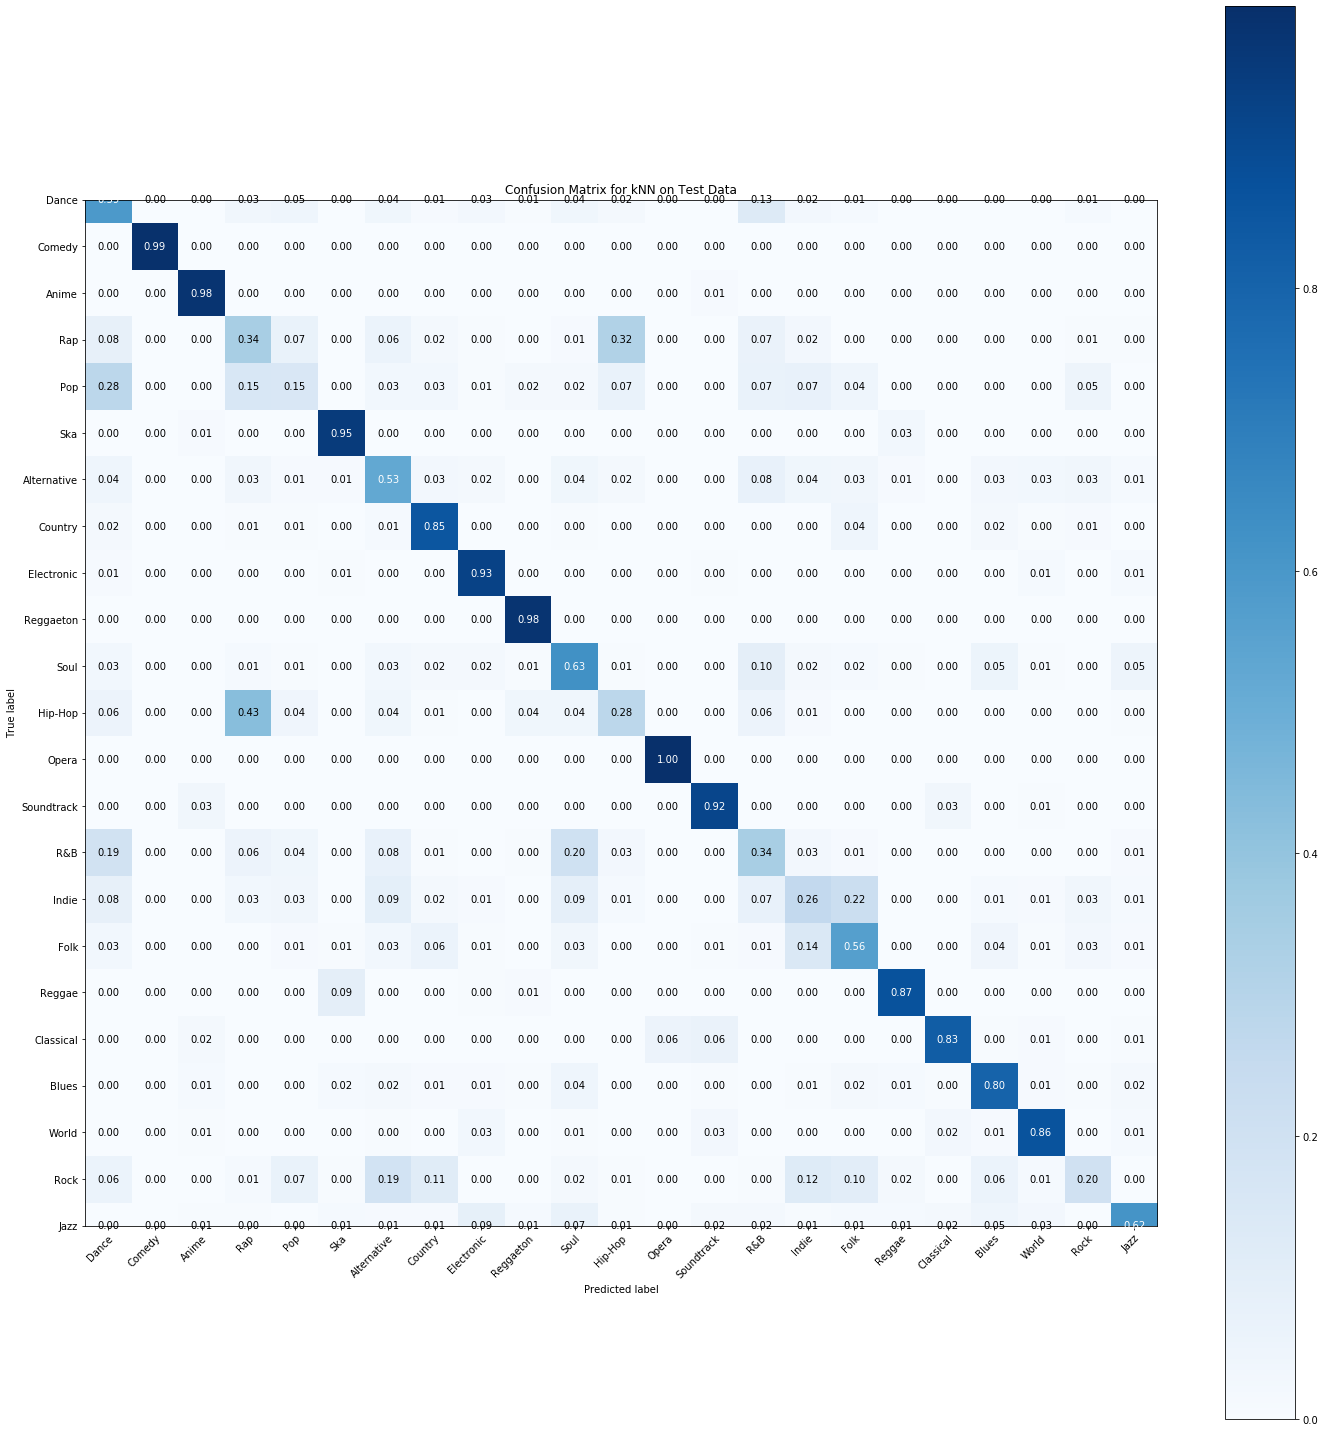

In [45]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots(figsize=(20,20))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plot normalized confusion matrix
class_names = ['Dance', 'Comedy', 'Anime', 'Rap', 'Pop', 'Ska', 'Alternative', 'Country', 'Electronic', 'Reggaeton',\
               'Soul', 'Hip-Hop', 'Opera', 'Soundtrack', 'R&B', 'Indie', 'Folk', 'Reggae', 'Classical', 'Blues', 'World',\
               'Rock', 'Jazz']
plot_confusion_matrix(np.asarray(y_test), np.asarray(predVector), classes=np.asarray(class_names), normalize=True,
                      title='Confusion Matrix for kNN on Test Data')
plt.show()